In [1]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import networkx as nx
from skimage.draw import line
import io

In [2]:
def quantize_image(image_np, n_colors):
    """
    This function quantizes an image into a specified number of colors using KMeans clustering.
    It reduces the color palette of the image to 'n_colors' colors, which can be useful for image compression
    or simplifying the image for further processing.

    Parameters:
    - image_np: A numpy array of the image to be quantized. Expected to be in the format (height, width, 3) for RGB images.
    - n_colors: The number of colors to reduce the image to.

    Returns:
    - quantized_image: The quantized image as a numpy array of the same shape as 'image_np' but with reduced color palette.
    """

    # Reshaping the image into a 2D array where each row represents a pixel and the three columns represent the RGB values.
    # This is necessary because KMeans clustering expects data in this format.
    pixels = image_np.reshape(-1, 3)
    
    # Performing KMeans clustering on the reshaped image data. 'n_clusters' is set to the desired number of colors.
    # The fit method finds the best 'n_colors' clusters of pixels in the color space of the image.
    kmeans = KMeans(n_clusters=n_colors)
    kmeans.fit(pixels)
    
    # Replacing each pixel's color with the color of the cluster center it belongs to.
    # 'kmeans.labels_' gives the cluster assignment for each pixel, and 'kmeans.cluster_centers_' gives the color of each cluster center.
    # This step effectively reduces the image's color palette to 'n_colors' colors.
    new_pixels = kmeans.cluster_centers_[kmeans.labels_]
    
    # Reshaping the quantized pixels back to the original image shape to get the quantized image.
    # The data type is set to 'uint8' to represent pixel values as integers between 0 and 255.
    quantized_image = new_pixels.reshape(image_np.shape).astype('uint8')
    
    return quantized_image

In [3]:
def create_indexed_color_image_at_resolution(quantized_image_np, target_width):
    """
    Create an indexed color image at a user specified resolution, maintaining the aspect ratio.
    
    Parameters:
    - quantized_image_np: Numpy array of the quantized image.
    - target_width: The target width for the output image.
    
    Returns:
    - indexed_color_image_resized: The indexed color image at the specified resolution.
    """
    from skimage.transform import resize
    
    # Calculate the new height to maintain the aspect ratio
    aspect_ratio = quantized_image_np.shape[0] / quantized_image_np.shape[1]
    target_height = int(target_width * aspect_ratio)
    
    # Resize the quantized image to the target resolution
    quantized_image_resized = resize(quantized_image_np, (target_height, target_width), 
                                      order=0, preserve_range=True, anti_aliasing=False).astype(int)
    
    # Calculate unique colors in the resized image
    unique_colors_resized, counts_resized = np.unique(quantized_image_resized.reshape(-1, 3), axis=0, return_counts=True)
    
    # Create a 2D array to hold the index of the color for each pixel in the resized image
    indexed_color_image_resized = np.zeros((target_height, target_width), dtype=int)
    
    # Iterate over unique colors to create a mapping from color to index for the resized image
    color_to_index_resized = {tuple(color): idx for idx, color in enumerate(unique_colors_resized)}
    
    # Populate the indexed_color_image_resized with the index of each pixel's color
    for i in range(target_height):
        for j in range(target_width):
            indexed_color_image_resized[i, j] = color_to_index_resized[tuple(quantized_image_resized[i, j])]
    
    return indexed_color_image_resized

In [4]:
# Function to calculate Euclidean distance between two points
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

# Function to draw a line and return pixel values along the line
def get_line_pixel_values(img, start, end):
    # Use skimage's line function to get pixel coordinates
    rr, cc = line(start[0], start[1], end[0], end[1])  # Note: line expects (y, x) format for start and end
    # Sample the pixel values along the line
    pixel_values = img[rr, cc]
    return pixel_values

In [5]:
# def find_and_plot_centroids(image, cell_value, n_clusters, save_path):
#     """
#     Find centroids of clusters formed by cells with a specific value in an image,
#     plot these centroids on the image, and save the figure.

#     Parameters:
#     - image: Numpy array of the indexed color image.
#     - cell_value: The cell value to cluster.
#     - n_clusters: Number of clusters to form.
#     - save_path: Path to save the figure with centroids.
#     """
#     # Step 1: Extract coordinates of cells with the specified value
#     coords = np.column_stack(np.where(image == cell_value))

#     # Step 2: Use KMeans to cluster these coordinates
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(coords)
#     centroids = kmeans.cluster_centers_

#     # Step 3: Round centroids to nearest integer to use as indices (2D pixel values)
#     centroids = np.rint(centroids).astype(int)

#     # Plot the original image
#     plt.figure(figsize=(10, 8))  # Optional: Adjust figure size as needed
#     plt.imshow(image)

#     # Step 4: Plot centroids as larger blobs
#     for centroid in centroids:
#         plt.scatter(centroid[1], centroid[0], s=200, c='red', marker='o')  # s is the size of the centroid blob

#     # Save the figure with centroids overlay
#     plt.savefig(save_path)
#     plt.close()  # Close the figure to free memory

#     return centroids

In [6]:
def create_fully_connected_graph(centroids):
    """
    Create a fully connected graph from a list of centroids.

    Parameters:
    - centroids: A list of centroids where each centroid is a tuple or list of (y, x) coordinates.

    Returns:
    - G: A fully connected networkx graph with nodes positioned at the centroids.
    """
    G = nx.Graph()

    # Add nodes with centroids positions
    for i, centroid in enumerate(centroids):
        G.add_node(i, pos=(centroid[1], centroid[0]))


    # Add nodes with centroids positions
    for i, centroid in enumerate(centroids):
        # Note: centroid is expected in (y, x) format, but pos is stored as (x, y) for consistency with plotting
        G.add_node(i, pos=(centroid[1], centroid[0]))

    # Connect each node to every other node (fully connected graph)
    for i in G.nodes:
        for j in G.nodes:
            if i != j:
                G.add_edge(i, j)

    pos = nx.get_node_attributes(G, 'pos')

    return G, pos


In [7]:
def calculate_max_distance_for_edges(G, pos, weight_multiplier=10, default_distance=100):
    """
    Calculate the maximum distance to set for edges in a graph based on the average of the shortest distances
    between each node and its nearest neighbor, adjusted by a weight multiplier.

    Parameters:
    - G: The graph (networkx.Graph).
    - pos: Dictionary of node positions {node: (x, y)}.
    - weight_multiplier: Multiplier to adjust the average shortest distance (default: 1.6).
    - default_distance: Default max distance in case there are no distances (default: 100).

    Returns:
    - max_distance: The calculated maximum distance to use for setting edges.
    """
    shortest_distances = []

    # Iterate through each node in the graph
    for node in G.nodes:
        node_pos = pos[node]
        distances = []
        # Calculate distance from this node to all other nodes
        for neighbor in G.nodes:
            if node != neighbor:
                neighbor_pos = pos[neighbor]
                distance = calculate_distance(node_pos, neighbor_pos)
                distances.append(distance)
        # Find the shortest distance for this node
        if distances:
            shortest_distances.append(min(distances))

    # Calculate the average of these shortest distances
    if shortest_distances:
        average_shortest_distance = np.mean(shortest_distances)
        max_distance = average_shortest_distance * weight_multiplier
    else:
        max_distance = default_distance  # Default value in case there are no distances

    return max_distance


In [8]:
def prune_graph_edges(G, max_distance, threshold_percentage, pos, color_image):
    """
    Prune edges from the graph based on two criteria:
    1. Remove edges where the percentage of a specific value (2) along the line between nodes is below a threshold.
    2. Remove edges that exceed a specified maximum distance.

    Parameters:
    - G: The input graph to be pruned.
    - max_distance: The maximum allowed distance between nodes for an edge to be retained.
    - threshold_percentage: The minimum percentage of a specific value (2) required along the line between nodes.
    - pos: Dictionary of node positions {node: (x, y)}.
    - indexed_color_image_resized: The indexed color image resized to the target width.

    Returns:
    - G_pruned: The pruned graph.
    """
    # Create a copy of the graph to modify
    G_pruned = G.copy()

    # First, prune based on the threshold percentage
    for edge in G_pruned.edges():
        node, neighbor = edge
        node_pos = pos[node]
        neighbor_pos = pos[neighbor]

        # Convert positions from (x, y) to (y, x) because image arrays are indexed as [row, column]
        node_pos_yx = (node_pos[1], node_pos[0])
        neighbor_pos_yx = (neighbor_pos[1], neighbor_pos[0])


        # Get pixel values along the line between node and neighbor
        line_pixel_values = get_line_pixel_values(color_image, node_pos_yx, neighbor_pos_yx)

        # Calculate unique values and their counts
        unique_values, counts = np.unique(line_pixel_values, return_counts=True)

        # # Check if the value 2 meets the threshold
        # if 3 in unique_values:
        #     index_of_2 = np.where(unique_values == 3)[0][0]
        #     percentage_of_2 = (counts[index_of_2] / sum(counts)) * 100
        #     if percentage_of_2 < threshold_percentage:
        #         # Remove the edge if it doesn't meet the threshold
        #         G_pruned.remove_edge(node, neighbor)
        
        # Determine the index for the last unique value, which is the target color for pruning
        target_color_index = len(unique_values) - 1  # Index of the last unique value
        target_color = unique_values[target_color_index]

        # Calculate the percentage of the target color along the line
        if target_color in unique_values:
            index_of_target_color = np.where(unique_values == target_color)[0][0]
            percentage_of_target_color = (counts[index_of_target_color] / sum(counts)) * 100
            if percentage_of_target_color < threshold_percentage:
                # Remove the edge if it doesn't meet the threshold
                G_pruned.remove_edge(node, neighbor)


        else:
            # Remove the edge if 2 is not among the unique values
            G_pruned.remove_edge(node, neighbor)

    # Then, prune based on the maximum distance
    for edge in list(G_pruned.edges()):
        node, neighbor = edge
        node_pos = pos[node]
        neighbor_pos = pos[neighbor]

        # Convert positions from (x, y) to (y, x) for distance calculation
        node_pos_yx = (node_pos[1], node_pos[0])
        neighbor_pos_yx = (neighbor_pos[1], neighbor_pos[0])

        # Calculate the distance between the node and its neighbor
        distance = calculate_distance(node_pos_yx, neighbor_pos_yx)

        # Check if the distance exceeds the maximum allowed distance
        if distance > max_distance:
            G_pruned.remove_edge(node, neighbor)

    return G_pruned

In [9]:
# define some variables
n_colors = 4     # Let's assume the user specified 3 colors
n_clusters = 10  # Number of clusters for free space (number of nodes)
threshold_percentage = 98 # User-defined threshold for deciding if an edge should be kept based on pixel values

# Load the image
image_path = '/home/asblab/aaron/s3/process_hdmaps/hdmap7.jpg'
image = Image.open(image_path)

# crop image until the first non white pixel is found
bbox = image.getbbox()
cropped_image = image.crop(bbox)

# Convert the image into numpy array, image_np.shape = (height, width, 3)
image_np = np.array(cropped_image)

# Quantize the image
quantized_image_np = quantize_image(image_np, n_colors)

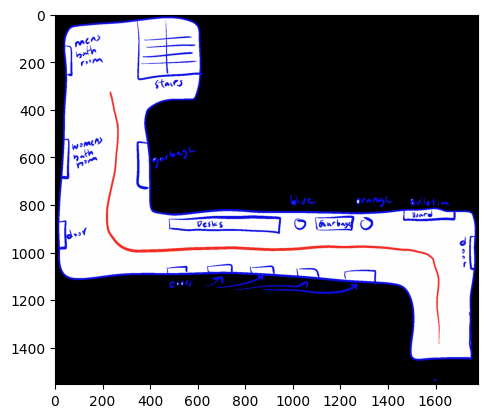

In [10]:
# plot quantized_image_np
plt.imshow(quantized_image_np)
plt.show()

In [11]:
target_width = quantized_image_np.shape[1]  # User specified width to downsize input image

In [12]:
print("unique colors: ", np.unique(quantized_image_np.reshape(-1, quantized_image_np.shape[2]), axis=0, return_counts=True))

unique colors:  (array([[  0,   0,   0],
       [ 13,  14, 227],
       [242,  43,  35],
       [254, 254, 254]], dtype=uint8), array([1800642,  117024,   22445,  822901]))


In [13]:
# Also calculate and print the number of unique colors after quantization
unique_colors_after, counts_after = np.unique(quantized_image_np.reshape(-1, quantized_image_np.shape[2]), axis=0, return_counts=True)
# Dictionary to hold color codes (in hex) and counts
unique_colors_counts_after = {f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}": count for color, count in zip(unique_colors_after, counts_after)}
print("Unique colors and their counts after quantization: ", unique_colors_counts_after)

# Create a 2D array to hold the index of the color for each pixel
indexed_color_image = np.zeros((quantized_image_np.shape[0], quantized_image_np.shape[1]), dtype=int)

# # Iterate over unique colors to create a mapping from color to index
# color_to_index = {tuple(color): idx for idx, color in enumerate(unique_colors_after)}

# Sort unique_colors_after to ensure white (should be #fefefe) is always the last item in the color_to_index list
sorted_unique_colors_after = sorted(unique_colors_after, key=lambda color: (color != [254, 254, 254]).all())

# Iterate over sorted unique colors to create a mapping from color to index
color_to_index = {tuple(color): idx for idx, color in enumerate(sorted_unique_colors_after)}

# Populate the indexed_color_image with the index of each pixel's color
# 0 = outside of map, 1 = walls, 2 = free space
for i in range(quantized_image_np.shape[0]):
    for j in range(quantized_image_np.shape[1]):
        indexed_color_image[i, j] = color_to_index[tuple(quantized_image_np[i, j])]

indexed_color_image_resized = create_indexed_color_image_at_resolution(quantized_image_np, target_width)

Unique colors and their counts after quantization:  {'#000000': 1800642, '#0d0ee3': 117024, '#f22b23': 22445, '#fefefe': 822901}


In [14]:
# Save the indexed color image at the new resolution with the target_width in the filename
plt.imsave(f'/home/asblab/aaron/s3/process_hdmaps/resized_{target_width}.png', indexed_color_image_resized)

In [15]:
def find_and_plot_centroids(image, cell_value, n_clusters, save_path):
    """
    Find centroids of clusters formed by cells with a specific value in an image,
    plot these centroids on the image, and save the figure.

    Parameters:
    - image: Numpy array of the indexed color image.
    - cell_value: The cell value to cluster.
    - n_clusters: Number of clusters to form.
    - save_path: Path to save the figure with centroids.
    """
    # Step 1: Extract coordinates of cells with the specified value
    coords = np.column_stack(np.where(image == cell_value))

    # Step 2: Use KMeans to cluster these coordinates
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(coords)
    centroids = kmeans.cluster_centers_

    # Step 3: Round centroids to nearest integer to use as indices (2D pixel values)
    centroids = np.rint(centroids).astype(int)

    # # Plot the original image
    # plt.figure(figsize=(10, 8))  # Optional: Adjust figure size as needed
    # plt.imshow(image)

    # # Step 4: Plot centroids as larger blobs
    # for centroid in centroids:
    #     plt.scatter(centroid[1], centroid[0], s=200, c='red', marker='o')  # s is the size of the centroid blob

    # # Save the figure with centroids overlay
    # plt.savefig(save_path)
    # plt.close()  # Close the figure to free memory

    return centroids

In [16]:
# Find and plot centroids
centroids = find_and_plot_centroids(indexed_color_image_resized, cell_value=2, n_clusters=12, save_path=f'/home/asblab/aaron/s3/process_hdmaps/with_centroids.png')
# print("centroids: ", centroids)

In [17]:
indexed_color_image_resized_modified = indexed_color_image_resized.copy()
indexed_color_image_resized_modified[indexed_color_image_resized == 2] = 3

In [18]:
# Save the indexed color image at the new resolution with the target_width in the filename
plt.imsave(f'/home/asblab/aaron/s3/process_hdmaps/resized_{target_width}_nopath.png', indexed_color_image_resized_modified)

Calculated max_distance based on average shortest distance: 275.4745146166544


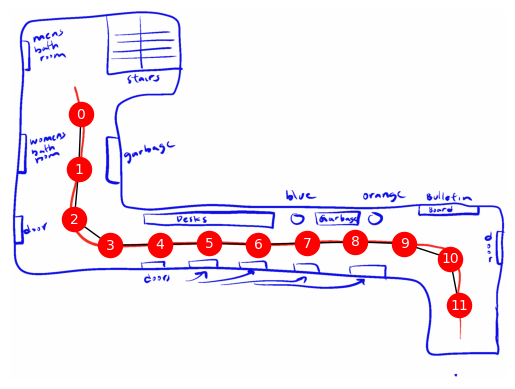

In [19]:
# Create a fully connected graph based on centroids
G, pos = create_fully_connected_graph(centroids)

# Calculate max distance for edges (for pruning of edges)
max_distance = calculate_max_distance_for_edges(G, pos, weight_multiplier=1.5)
print(f"Calculated max_distance based on average shortest distance: {max_distance}")

pruned_G = prune_graph_edges(G, max_distance, threshold_percentage, pos, indexed_color_image_resized_modified)
# Reordering nodes of pruned_G from top left to bottom right in a diagonal ordering
sorted_nodes = sorted(pruned_G.nodes(data='pos'), key=lambda x: x[1][0] + x[1][1])  # Sort nodes by the sum of x and y coordinates
mapping = {node[0]: i for i, node in enumerate(sorted_nodes)}  # Create a mapping for node renaming
pruned_G = nx.relabel_nodes(pruned_G, mapping)  # Relabel nodes based on diagonal order

mask = (quantized_image_np == [0, 0, 0]).all(axis=-1)
quantized_image_np[mask] = [254, 254, 254]

# Plot the original image and centroids
plt.imshow(quantized_image_np, cmap='viridis')

# Draw the networkx graph on top of the matplotlib plot
pos = nx.get_node_attributes(pruned_G, 'pos')
nx.draw(pruned_G, pos, with_labels=True, node_color='red', edge_color='black', node_size=300, font_size=10, font_color='white')

# save image with the nx graph overlaid, the image shouldd minimize borders
plt.axis('tight')
plt.axis('off')
plt.savefig(f'/home/asblab/aaron/s3/process_hdmaps/input_hdmap.png', bbox_inches='tight', pad_inches=0, dpi=300)

In [20]:
# save quantized_image_np to a pickle
import pickle

# Save the quantized_image_np array to a pickle file
pickle_file_path = '/home/asblab/aaron/s3/process_hdmaps/quantized_image_np.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(quantized_image_np, file)

print(f"quantized_image_np saved to {pickle_file_path}")

# save pruned_G as a pickle
pickle_file_path = '/home/asblab/aaron/s3/process_hdmaps/pruned_G.pkl'
with open(pickle_file_path, 'wb') as file:
    pickle.dump(pruned_G, file)

print(f"pruned_G saved to {pickle_file_path}")

quantized_image_np saved to /home/asblab/aaron/s3/process_hdmaps/quantized_image_np.pkl
pruned_G saved to /home/asblab/aaron/s3/process_hdmaps/pruned_G.pkl


In [21]:
# load the pkl file
hdmap_np = pickle.load(open('/home/asblab/aaron/s3/process_hdmaps/quantized_image_np.pkl', 'rb'))
hdmap_graph = pickle.load(open('/home/asblab/aaron/s3/process_hdmaps/pruned_G.pkl', 'rb'))

In [22]:
estimated_nodes = [1, 5, 8, 10]

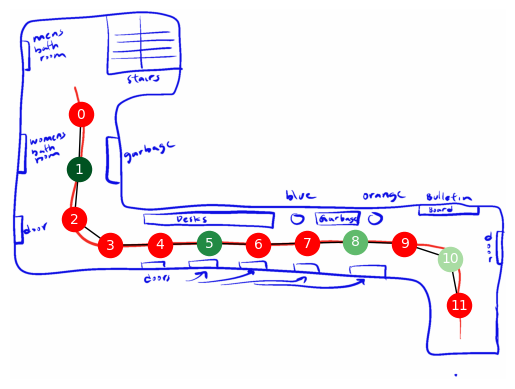

In [23]:
# Plot the hdmap_np image
plt.imshow(hdmap_np)

# Get positions of all nodes
pos = nx.get_node_attributes(hdmap_graph, 'pos')

# Draw all nodes not in estimated_nodes in red
nx.draw_networkx_nodes(hdmap_graph, pos, nodelist=set(hdmap_graph.nodes()) - set(estimated_nodes), node_color='red', node_size=300)

# Adjust the gradient generation to ensure it ranges from a fixed dark green to light green
num_estimated_nodes = len(estimated_nodes)
# Define the start and end points for the green shades (avoiding too light)
start_green = 0.95  # Lighter green, but not too light
end_green = 0.35   # Darker green
green_shades = [plt.cm.Greens(start_green - (start_green - end_green) * i / (num_estimated_nodes - 1)) for i in range(num_estimated_nodes)]

# Draw nodes in estimated_nodes with the corresponding shade of green
for i, node in enumerate(estimated_nodes):
    nx.draw_networkx_nodes(hdmap_graph, pos, nodelist=[node], node_color=[green_shades[i]], node_size=300)

# Draw edges
nx.draw_networkx_edges(hdmap_graph, pos, edge_color='black')

# Draw node labels
nx.draw_networkx_labels(hdmap_graph, pos, font_size=10, font_color='white')

plt.axis('tight')
plt.axis('off')
plt.savefig(f'/home/asblab/aaron/s3/process_hdmaps/input_hdmap_pose.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()